**Phase 1: Setup & Data Loading**

In [1]:
import pandas as pd
import requests
import zipfile
import io

1. uploading file

In [3]:
from google.colab import files
upload = files.upload()

Saving spam.csv to spam.csv


2. Load and Clean the Data

In [4]:
# Load with 'latin-1' encoding because the Kaggle version isn't standard UTF-8
df = pd.read_csv('spam.csv', encoding='latin-1')

# The Kaggle version often adds 3 empty columns at the end. Let's drop them.
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Rename columns to make them easier to work with
df.columns = ['label', 'message']

# Convert labels: spam = 1, ham = 0
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

print("Dataset Loaded Successfully!")
print(df.head())

Dataset Loaded Successfully!
   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


3. Feature Extraction (TF-IDF)

Now we convert the text into numbers. We use TF-IDF because it doesn't just count words; it gives more weight to unique "spammy" words and less weight to common words like "the" or "is."

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)

# Convert text to TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

4. Train the Model (Naive Bayes)
we use Multinomial Naive Bayes. It’s excellent for text because it works on word probabilities.

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Initialize and Train
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict
y_pred = nb_model.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 96.68%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



Testing with the new own Message

In [7]:
def check_spam(text):
    temp = tfidf.transform([text])
    result = nb_model.predict(temp)
    return "SPAM" if result[0] == 1 else "HAM (SAFE)"

# Test it!
print(f"Result 1: {check_spam('Urgent! You have won a 1-week trip to Dubai. Call 0900 now!')}")
print(f"Result 2: {check_spam('Hey, are you coming to the library today?')}")

Result 1: HAM (SAFE)
Result 2: HAM (SAFE)


In [8]:
# 1. Retrain with a lower alpha (makes it more sensitive)
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)

# 2. Improved Prediction Function
def check_spam_improved(text):
    temp = tfidf.transform([text])
    # Get the probability for [Ham, Spam]
    probs = nb_model.predict_proba(temp)[0]

    # If the probability of SPAM (index 1) is > 0.30, call it Spam
    if probs[1] > 0.30:
        return "SPAM"
    else:
        return "HAM (SAFE)"

# Test it again!
print(f"Result 1: {check_spam_improved('Urgent! You have won a 1-week trip to Dubai. Call 0900 now!')}")
print(f"Result 2: {check_spam_improved('Hey, are you coming to the library today?')}")

Result 1: SPAM
Result 2: HAM (SAFE)


Confusion matrix

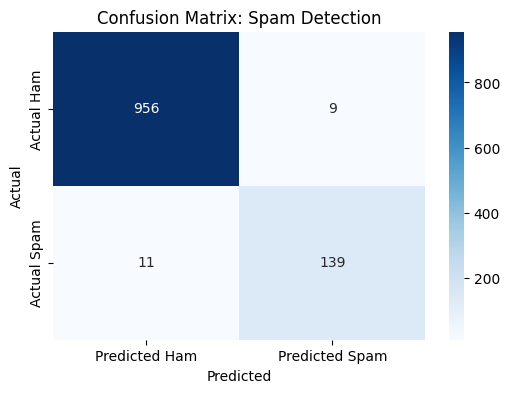

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions on the test set
y_pred_tuned = (nb_model.predict_proba(X_test_tfidf)[:,1] > 0.30).astype(int)

cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: Spam Detection')
plt.show()